<a href="https://colab.research.google.com/github/AgniKoko/DIP_HW02/blob/main/DIP_HW02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Κοκορότσικου Αγνή Ιωάννα, 58767
[GitHub repository](https://github.com/AgniKoko/DIP_HW02)

# Step 1

**Άσκηση 5 - Τεχνικές Συμπίεσης εικόνας**

Χρήσιμες Βιβλιοθήκες:
* Documentation OpenCV:      https://docs.opencv.org/4.x/index.html
* Documentation SciPy:       https://docs.scipy.org/doc/scipy/
* Documentation skimage:     https://scikit-image.org/docs/stable/api/api.html
* Documentation Matlplotlib: https://matplotlib.org/stable/index.html


In [110]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage.util import view_as_blocks
import heapq
from collections import defaultdict
import urllib.request

image = cv2.imread('dog_square.png')
ycbcr_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
Y, Cb, Cr = cv2.split(ycbcr_image)

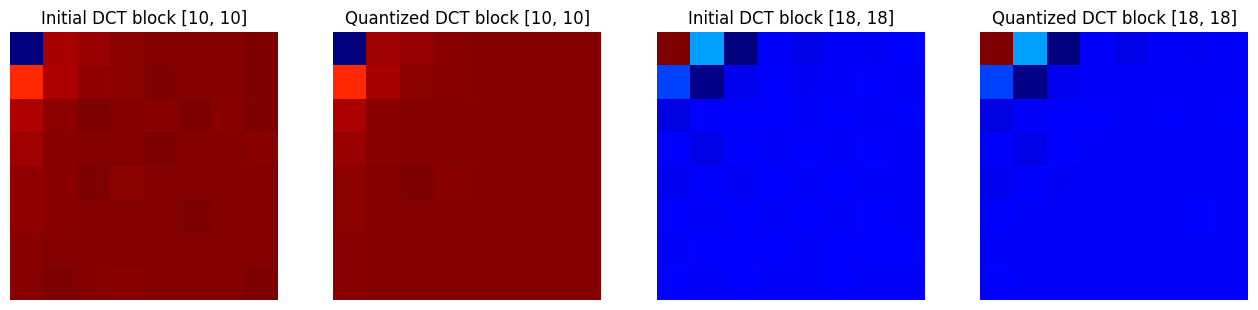

In [111]:
# Function to compute the 2D DCT of an 8x8 block
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

# Process each channel with block-wise DCT and quantization
def process_channel(channel):
    blocks = view_as_blocks(channel, block_shape=(8, 8))
    dct_blocks = np.zeros_like(blocks)
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            block = blocks[i, j]
            dct_blocks[i, j] = dct2(block - 128)
    return dct_blocks

Y_processed = process_channel(Y.astype(int))
Cb_processed = process_channel(Cb.astype(int))
Cr_processed = process_channel(Cr.astype(int))

Y_blocks = view_as_blocks(Y.astype(int), block_shape=(8, 8))

plt.figure(figsize=(16, 16))
plt.subplot(4, 4, 1)
plt.imshow(dct2(Y_blocks[10, 10]-128), cmap='jet')
plt.title('Initial DCT block [10, 10]')
plt.axis('off')
plt.subplot(4, 4, 2)
plt.imshow(Y_processed[10, 10], cmap='jet')
plt.title('Quantized DCT block [10, 10]')
plt.axis('off')
plt.subplot(4, 4, 3)
plt.imshow(dct2(Y_blocks[18, 18]-128), cmap='jet')
plt.title('Initial DCT block [18, 18]')
plt.axis('off')
plt.subplot(4, 4, 4)
plt.imshow(Y_processed[18, 18], cmap='jet')
plt.title('Quantized DCT block [18, 18]')
plt.axis('off')
plt.show()

In [112]:
nb, mb = Y_processed.shape[:2]
dc_values = np.zeros((nb, mb))

def dc_values_compute(channel):
  for i in range(channel.shape[0]):
      for j in range(channel.shape[1]):
        coeffs = channel[i, j]
        dc_values[i, j] = coeffs[0, 0]
  return dc_values

Y_dc_values = dc_values_compute(Y_processed)
Cb_dc_values = dc_values_compute(Cb_processed)
Cr_dc_values = dc_values_compute(Cr_processed)

combined_dc_values = np.dstack((Y_dc_values, Cb_dc_values, Cr_dc_values))

print(combined_dc_values.shape)
print(combined_dc_values[:10,:10, 0])

(64, 64, 3)
[[-146. -134. -129. -134. -135. -142. -148. -154. -156. -156.]
 [-154. -134. -123. -120. -119. -119. -119. -121. -132. -138.]
 [-157. -137. -124. -120. -113. -109. -103. -108. -113. -117.]
 [-176. -162. -155. -147. -145. -131. -118. -114. -116. -117.]
 [-205. -205. -205. -200. -196. -179. -166. -153. -148. -149.]
 [-239. -245. -250. -245. -237. -223. -213. -204. -205. -205.]
 [-254. -266. -281. -276. -265. -255. -246. -239. -244. -245.]
 [-277. -294. -296. -297. -282. -264. -256. -255. -259. -262.]
 [-284. -293. -294. -289. -279. -268. -258. -252. -250. -242.]
 [-268. -281. -281. -269. -257. -244. -228. -227. -220. -192.]]


**Διαφορική Κωδικοποίηση**

1. Σχεδιάστε μάσκες για τους ακόλουθους predictors ως χωρικά φίλτρα:

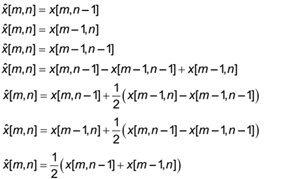
2. Εφαρμόστε στην εικόνα τους predictors χρησιμοποιώντας την cv2.filter2D, και προβάλετε την έξοδο κάθε predictor

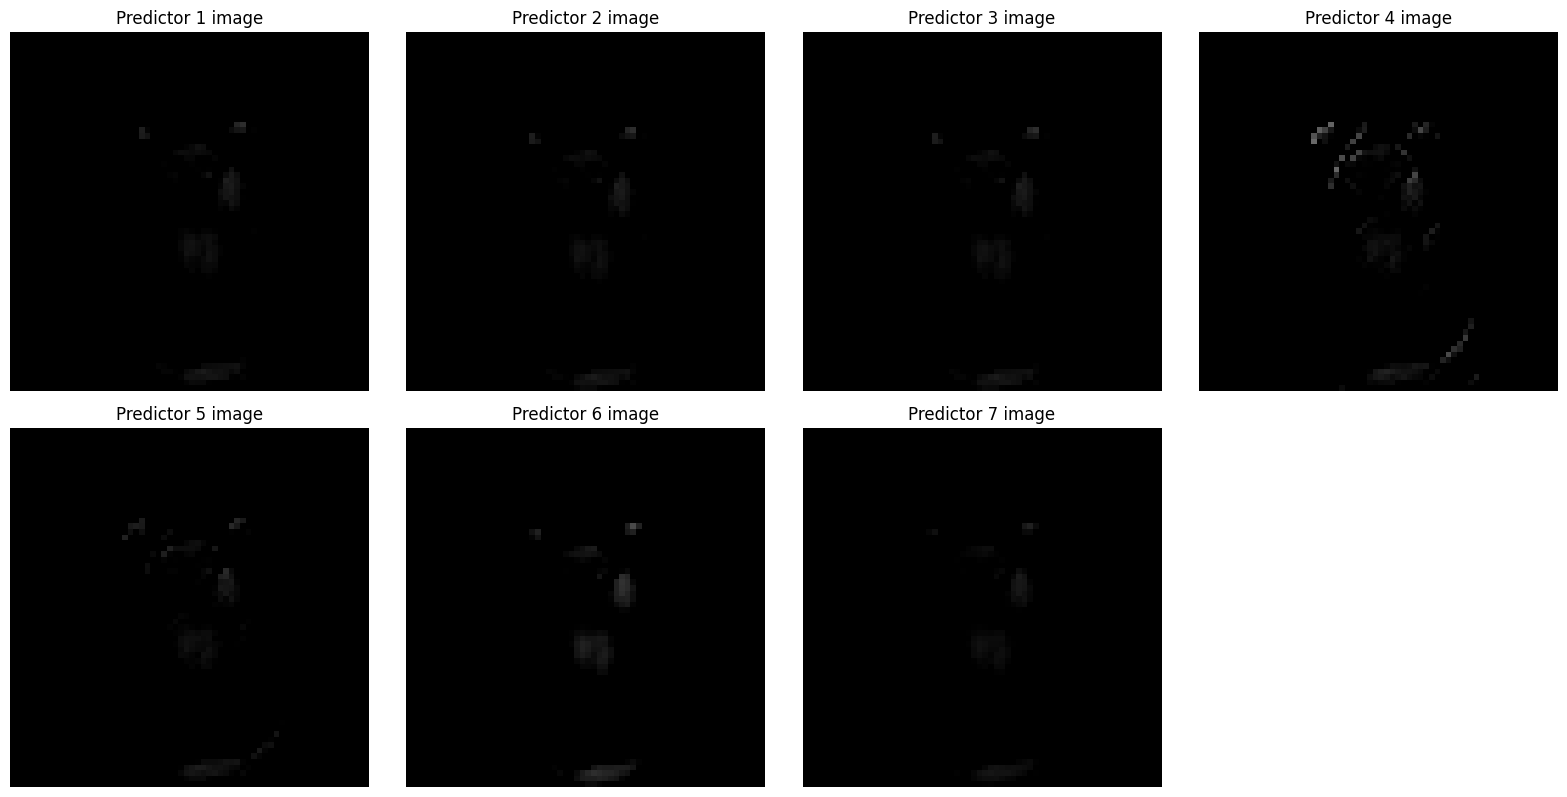

In [113]:
predictor1_mask = np.array([[0, 0, 0], [1, 0, 0], [0, 0, 0]])
predictor2_mask = np.array([[0, 1, 0], [0, 0, 0], [0, 0, 0]])
predictor3_mask = np.array([[1, 0, 0], [0, 0, 0], [0, 0, 0]])
predictor4_mask = predictor1_mask - predictor3_mask + predictor2_mask
predictor5_mask = predictor1_mask + 0.5 * (predictor2_mask - predictor3_mask)
predictor6_mask = predictor2_mask + 0.5 * (predictor1_mask + predictor3_mask)
predictor7_mask = 0.5 * (predictor1_mask + predictor2_mask)

# Apply predictors as filters
predicted_image_1 = cv2.filter2D(combined_dc_values, -1, predictor1_mask)
predicted_image_2 = cv2.filter2D(combined_dc_values, -1, predictor2_mask)
predicted_image_3 = cv2.filter2D(combined_dc_values, -1, predictor3_mask)
predicted_image_4 = cv2.filter2D(combined_dc_values, -1, predictor4_mask)
predicted_image_5 = cv2.filter2D(combined_dc_values, -1, predictor5_mask)
predicted_image_6 = cv2.filter2D(combined_dc_values, -1, predictor6_mask)
predicted_image_7 = cv2.filter2D(combined_dc_values, -1, predictor7_mask)

predicted_images = [
    predicted_image_1,
    predicted_image_2,
    predicted_image_3,
    predicted_image_4,
    predicted_image_5,
    predicted_image_6,
    predicted_image_7
]

plt.figure(figsize=(16, 16))
for i, image in enumerate(predicted_images, start=1):
    plt.subplot(4, 4, i)
    plt.imshow(image.astype(int), cmap='gray')
    plt.title(f"Predictor {i} image")
    plt.axis('off')
plt.tight_layout()
plt.show()

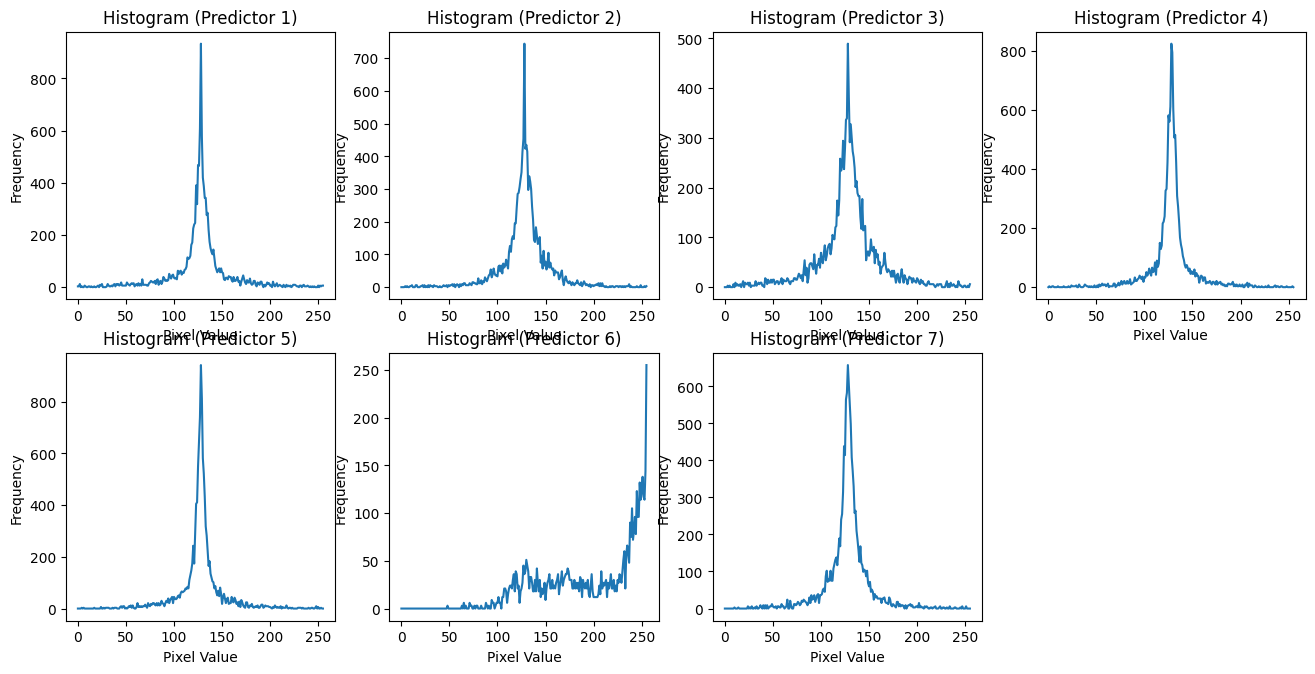

Entropy for Original image: 4.3494
Entropy for Predictor 1: 6.2641
Entropy for Predictor 2: 6.2611
Entropy for Predictor 3: 6.6977
Entropy for Predictor 4: 5.8609
Entropy for Predictor 5: 5.8588
Entropy for Predictor 6: 6.9336
Entropy for Predictor 7: 6.0399

Least entropy is entropy_5 = 5.858804575452405


In [114]:
# Compute prediction errors for each predictor
prediction_error_1 = combined_dc_values.astype(int) - predicted_image_1.astype(int) # int ---> Epeidh einai unit8, gia na mhn kanei clip sto 0
prediction_error_2 = combined_dc_values.astype(int) - predicted_image_2.astype(int)
prediction_error_3 = combined_dc_values.astype(int) - predicted_image_3.astype(int)
prediction_error_4 = combined_dc_values.astype(int) - predicted_image_4.astype(int)
prediction_error_5 = combined_dc_values.astype(int) - predicted_image_5.astype(int)
prediction_error_6 = combined_dc_values.astype(int) - predicted_image_6.astype(int)
prediction_error_7 = combined_dc_values.astype(int) - predicted_image_7.astype(int)

prediction_errors = [
    prediction_error_1,
    prediction_error_2,
    prediction_error_3,
    prediction_error_4,
    prediction_error_5,
    prediction_error_6,
    prediction_error_7
]

# Compute histograms of prediction errors
histogram_original,_ = np.histogram(image.flatten(), bins=256, range=(0, 255))
histogram_1,_ = np.histogram(prediction_error_1.flatten(), bins=256, range=(-128, 128))
histogram_2,_ = np.histogram(prediction_error_2.flatten(), bins=256, range=(-128, 128))
histogram_3,_ = np.histogram(prediction_error_3.flatten(), bins=256, range=(-128, 128))
histogram_4,_ = np.histogram(prediction_error_4.flatten(), bins=256, range=(-128, 128))
histogram_5,_ = np.histogram(prediction_error_5.flatten(), bins=256, range=(-128, 128))
histogram_6,_ = np.histogram(prediction_error_6.flatten(), bins=256, range=(-128, 128))
histogram_7,_ = np.histogram(prediction_error_7.flatten(), bins=256, range=(-128, 128))

histograms = [
    histogram_1,
    histogram_2,
    histogram_3,
    histogram_4,
    histogram_5,
    histogram_6,
    histogram_7
]

plt.figure(figsize=(16, 16))
for i, histogram in enumerate(histograms, start=1):
    plt.subplot(4, 4, i)
    plt.plot(histogram)
    plt.title(f"Histogram (Predictor {i})")
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
plt.show()

def compute_entropy(histogram):
    histogram_normalized = histogram / histogram.sum()
    entropy_value = -np.sum(histogram_normalized * np.log2(histogram_normalized + 1e-10))
    return entropy_value

enrory_original=compute_entropy(histogram_original)
entropy_1 = compute_entropy(histogram_1)
entropy_2 = compute_entropy(histogram_2)
entropy_3 = compute_entropy(histogram_3)
entropy_4 = compute_entropy(histogram_4)
entropy_5 = compute_entropy(histogram_5)
entropy_6 = compute_entropy(histogram_6)
entropy_7 = compute_entropy(histogram_7)

print(f"Entropy for Original image: {enrory_original:.4f}")
print(f"Entropy for Predictor 1: {entropy_1:.4f}")
print(f"Entropy for Predictor 2: {entropy_2:.4f}")
print(f"Entropy for Predictor 3: {entropy_3:.4f}")
print(f"Entropy for Predictor 4: {entropy_4:.4f}")
print(f"Entropy for Predictor 5: {entropy_5:.4f}")
print(f"Entropy for Predictor 6: {entropy_6:.4f}")
print(f"Entropy for Predictor 7: {entropy_7:.4f}")

entropies = [
    entropy_1,
    entropy_2,
    entropy_3,
    entropy_4,
    entropy_5,
    entropy_6,
    entropy_7
]

min_entropy = min(entropies)
min_idx = entropies.index(min_entropy) + 1
print("")
print(f"Least entropy is entropy_{min_idx} = {min_entropy}")
min_prediction_error = prediction_errors[min_idx]

In [115]:
# Huffman coding
class HuffmanNode:
    def __init__(self, value, frequency):
        self.value = value
        self.frequency = frequency
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequency < other.frequency

def build_huffman_tree(frequencies):
    heap = [HuffmanNode(value, freq) for value, freq in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(None, node1.frequency + node2.frequency)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    return heap[0]

def build_huffman_codes(tree, prefix="", codebook={}):
    if tree.value is not None:
        codebook[tree.value] = prefix
    else:
        if tree.left:
            build_huffman_codes(tree.left, prefix + "0", codebook)
        if tree.right:
            build_huffman_codes(tree.right, prefix + "1", codebook)
    return codebook

def huffman_encode(data):
    frequencies = defaultdict(int)
    for item in data:
        frequencies[item] += 1
    huffman_tree = build_huffman_tree(frequencies)
    huffman_codes = build_huffman_codes(huffman_tree)
    encoded_data = ''.join([huffman_codes[item] for item in data])
    return encoded_data, huffman_codes

In [117]:
Y_flattened = (min_prediction_error[:,:,0]).flatten()
Cb_flattened = (min_prediction_error[:,:,1]).flatten()
Cr_flattened = (min_prediction_error[:,:,2]).flatten()

encoded_Y_dc, huffman_codes_Y_dc = huffman_encode(Y_flattened)
encoded_Cb_dc, huffman_codes_Cb_dc = huffman_encode(Cb_flattened)
encoded_Cr_dc, huffman_codes_Cr_dc = huffman_encode(Cr_flattened)

encoded_dc_bit_stream = encoded_Y_dc + encoded_Cb_dc + encoded_Cr_dc

# Display the first 100 bits of the final bit stream for brevity
print(f"Encoded Bit Stream (first 100 bits): {encoded_dc_bit_stream[:100]}")

compressed_size = len(encoded_dc_bit_stream)
print(f"Compressed Size: {compressed_size} bits")

                                      # Στο compressed size συμπεριλαμβανουμε και τα bits για το καθε συμβολο



Encoded Bit Stream (first 100 bits): 0100111011001011101101010101001010111011101101011100111101101000011000011101110111000000110011010111
Compressed Size: 100170 bits


# Step 2

**Κωδικοποίηση Εντροπίας των κβαντισμένων συντελεστών**

Εκτελέστε τον ακόλουθο κώδικα που υλοποιήσει συμπίεση Huffman στα κβαντισμένα DCT blocks.
1. Συμπληρώστε τον κώδικα ώστε να υπολογίσετε τον λόγο συμπίεσης που επιτυγχάνεται.
2. Προβάλετε και παρατηρείστε τους κώδικες Huffman που δημιουργούνται.

Εκτελέστε τον ακόλουθο κώδικα ώστε να οπτικοποιήσετε χωρικά τους συντελεστές DCT

In [118]:
# Zigzag order                            # Ξεδιπλωμα σειρας των block
zigzag_index = np.array([
    [0, 1, 5, 6, 14, 15, 27, 28],
    [2, 4, 7, 13, 16, 26, 29, 42],
    [3, 8, 12, 17, 25, 30, 41, 43],
    [9, 11, 18, 24, 31, 40, 44, 53],
    [10, 19, 23, 32, 39, 45, 52, 54],
    [20, 22, 33, 38, 46, 51, 55, 60],
    [21, 34, 37, 47, 50, 56, 59, 61],
    [35, 36, 48, 49, 57, 58, 62, 63]
])

def zigzag_scan(block):
    return block.flatten()[zigzag_index.flatten()]

Y_zigzag = [zigzag_scan(block) for block in Y_processed.reshape(-1, 8, 8)]
Cb_zigzag = [zigzag_scan(block) for block in Cr_processed.reshape(-1, 8, 8)]
Cr_zigzag = [zigzag_scan(block) for block in Cb_processed.reshape(-1, 8, 8)]

Y_flattened = np.concatenate(Y_zigzag).astype(int)
Cb_flattened = np.concatenate(Cb_zigzag).astype(int)
Cr_flattened = np.concatenate(Cr_zigzag).astype(int)

# Πρεπει να αφαιρεσουμε τους DC συντελεστες διοτι ακολουθουν διαφορετικη διαδικασια
def compute_non_dc_values(flat_channel):
  idx = np.arange(63, flat_channel.size, 64)
  non_dc_values = np.delete(flat_channel, idx)
  return non_dc_values

Y_non_dc = compute_non_dc_values(Y_flattened)
Cb_non_dc = compute_non_dc_values(Cb_flattened)
Cr_non_dc = compute_non_dc_values(Cr_flattened)

encoded_Y, huffman_codes_Y = huffman_encode(Y_non_dc)
encoded_Cb, huffman_codes_Cb = huffman_encode(Cb_non_dc)
encoded_Cr, huffman_codes_Cr = huffman_encode(Cr_non_dc)

encoded_bit_stream = encoded_Y + encoded_Cb + encoded_Cr
print(f"Encoded Bit Stream (first 100 bits): {encoded_bit_stream[:100]}")
compressed_size = len(encoded_bit_stream)
print(f"Compressed Size: {compressed_size} bits")

compression_ratio = compressed_size / original_size
print(f"Compression Ratio: {compression_ratio:.2f}")

Encoded Bit Stream (first 100 bits): 0110101101100101100101111111111111011111110110111001010111111100000010110011000000111111111111110111
Compressed Size: 1589747 bits
Compression Ratio: 8.09


In [119]:
# Creating a func that calculates the size in bytes of a huffman dictionary
def dict_size_calc(huffman_dict):
  total_size = 0
  for i, j in huffman_dict.items():
      key_size = 4                  # np.float32 is 4 bytes
      value_size = len(j)           # number of bits in the Huffman code string
      value_size_bytes = (value_size + 7) // 8  # bits to full bytes
      total_size += key_size + value_size_bytes
  return total_size

In [120]:
# Calculating Compression Ratio

# Calculating the size in bytes of orignal image
B, G, R = cv2.split(image)

image_size_bytes = B.nbytes + G.nbytes + R.nbytes

# Calculating the size in bytes of compressed image
encoded_data_bytes = (len(encoded_bit_stream)+len(encoded_dc_bit_stream))//8

huffman_codes_bytes = dict_size_calc(huffman_codes_Y)+dict_size_calc(huffman_codes_Cr)+dict_size_calc(huffman_codes_Cb)+dict_size_calc(huffman_codes_Y_dc)+dict_size_calc(huffman_codes_Cb_dc)+dict_size_calc(huffman_codes_Cr_dc)

compression_ratio = (encoded_data_bytes+huffman_codes_bytes)/image_size_bytes
print(f"The final Compression Ratio is: {compression_ratio:.2f}")

The final Compression Ratio is: 2.76
